In [4]:
import networkx as nx
print(nx.__version__)

3.5


Number of nodes: 5000
Number of edges: 9996
Sample size: 750

Random Node Sampling:
 Sample 1 -> nodes: 750 edges: 212
 Sample 2 -> nodes: 750 edges: 205

Random Edge Sampling:
 Sample 1 -> nodes: 751 edges: 450
 Sample 2 -> nodes: 751 edges: 449


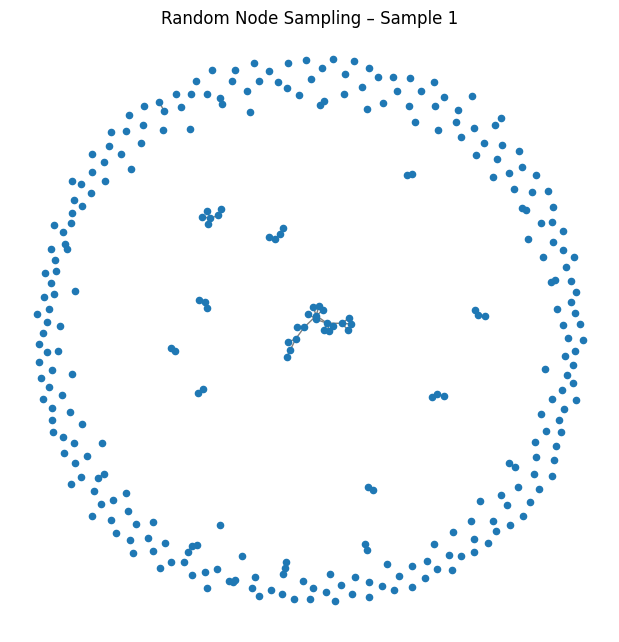

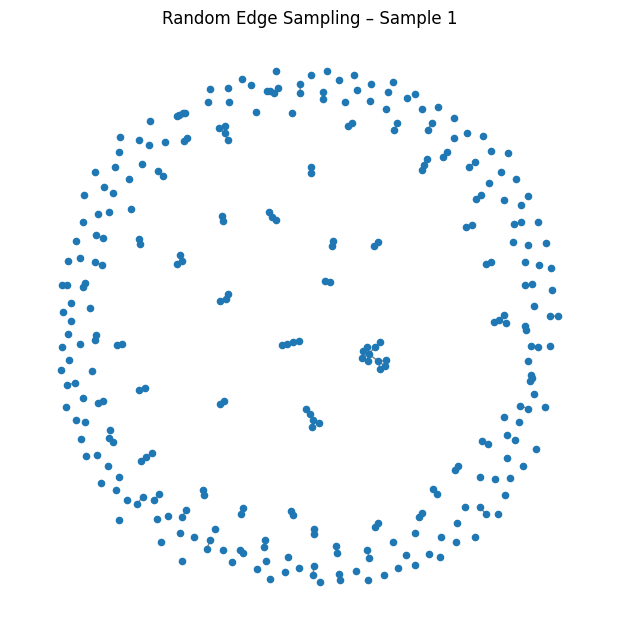

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Parameters
n = 5000   # number of nodes
m = 2      # edges each new node adds

# Generate Barabási–Albert graph
G = nx.barabasi_albert_graph(n, m)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# -----------------------------------------------------------
# Sampling Methods
# -----------------------------------------------------------

sample_size = int(0.15 * n)  # 15% of nodes
print("Sample size:", sample_size)

# -----------------------------------------------------------
# 1. RANDOM NODE SAMPLING (RNS)
# -----------------------------------------------------------
def random_node_sampling(G, sample_size):
    sampled_nodes = random.sample(list(G.nodes()), sample_size)
    return G.subgraph(sampled_nodes).copy()

# two independent samples
RNS_sample1 = random_node_sampling(G, sample_size)
RNS_sample2 = random_node_sampling(G, sample_size)

print("\nRandom Node Sampling:")
print(" Sample 1 -> nodes:", RNS_sample1.number_of_nodes(), "edges:", RNS_sample1.number_of_edges())
print(" Sample 2 -> nodes:", RNS_sample2.number_of_nodes(), "edges:", RNS_sample2.number_of_edges())

# -----------------------------------------------------------
# 2. RANDOM EDGE SAMPLING (RES)
# -----------------------------------------------------------
def random_edge_sampling(G, sample_size):
    # determine number of edges needed to approx. sample_size nodes
    edges = list(G.edges())
    random.shuffle(edges)

    sampled_edges = []
    sampled_nodes = set()

    for u, v in edges:
        sampled_edges.append((u, v))
        sampled_nodes.update([u, v])
        if len(sampled_nodes) >= sample_size:
            break

    H = nx.Graph()
    H.add_nodes_from(sampled_nodes)
    H.add_edges_from(sampled_edges)
    return H

# two independent samples
RES_sample1 = random_edge_sampling(G, sample_size)
RES_sample2 = random_edge_sampling(G, sample_size)

print("\nRandom Edge Sampling:")
print(" Sample 1 -> nodes:", RES_sample1.number_of_nodes(), "edges:", RES_sample1.number_of_edges())
print(" Sample 2 -> nodes:", RES_sample2.number_of_nodes(), "edges:", RES_sample2.number_of_edges())

# -----------------------------------------------------------
# Optional: visualize one sample per method (small subset)
# -----------------------------------------------------------

def visualize_sample(H, title):
    plt.figure(figsize=(6, 6))
    nx.draw_spring(H, node_size=20, edge_color="gray")
    plt.title(title)
    plt.show()

# visualize smaller subgraphs (only 300 nodes)
visualize_sample(nx.subgraph(RNS_sample1, list(RNS_sample1.nodes())[:300]),
                 "Random Node Sampling – Sample 1")

visualize_sample(nx.subgraph(RES_sample1, list(RES_sample1.nodes())[:300]),
                 "Random Edge Sampling – Sample 1")

In [5]:
!python --version

Python 3.13.5



Forest Fire Sampling:
 Sample 1 -> nodes: 750 edges: 1055
 Sample 2 -> nodes: 751 edges: 1094


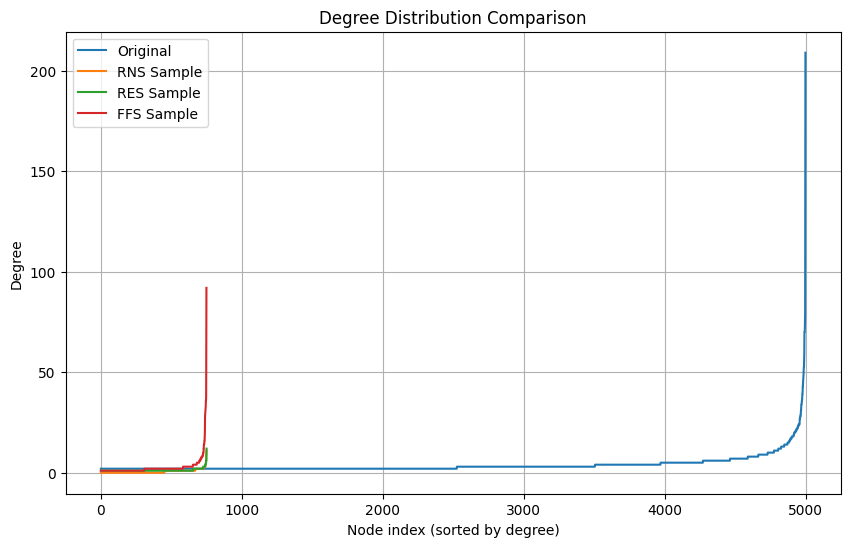

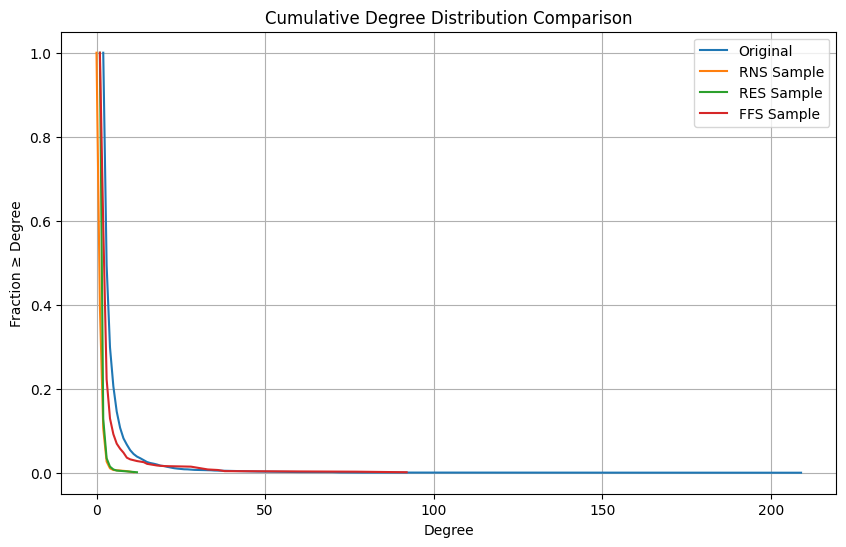

In [3]:
# -----------------------------------------------------------
# FOREST FIRE SAMPLING (FFS)
# Tried manually without using any packages
# -----------------------------------------------------------
def forest_fire_sample(G, sample_size, p=0.35):  
    # p = forward burning probability (simplified FFS)
    import random
    start = random.choice(list(G.nodes()))
    visited = set([start])
    queue = [start]

    while queue and len(visited) < sample_size:
        cur = queue.pop(0)

        neighbors = list(G.neighbors(cur))
        random.shuffle(neighbors)

        # burn neighbors with prob p
        burned = [nb for nb in neighbors if random.random() < p]

        for nb in burned:
            if nb not in visited:
                visited.add(nb)
                queue.append(nb)

        if len(visited) >= sample_size:
            break

    return G.subgraph(visited).copy()


# two independent forest fire samples
FFS_sample1 = forest_fire_sample(G, sample_size)
FFS_sample2 = forest_fire_sample(G, sample_size)

print("\nForest Fire Sampling:")
print(" Sample 1 -> nodes:", FFS_sample1.number_of_nodes(), "edges:", FFS_sample1.number_of_edges())
print(" Sample 2 -> nodes:", FFS_sample2.number_of_nodes(), "edges:", FFS_sample2.number_of_edges())


# -----------------------------------------------------------
# Degree distribution helper functions
# -----------------------------------------------------------
def degree_distribution(G):
    degs = [d for _, d in G.degree()]
    return sorted(degs)

def cumulative_distribution(degrees):
    n = len(degrees)
    return [sum(d >= x for d in degrees) / n for x in degrees]


# -----------------------------------------------------------
# VISUAL COMPARISON OF DEGREE DISTRIBUTIONS
# -----------------------------------------------------------

# Prepare degree lists
orig_deg = degree_distribution(G)
rns_deg = degree_distribution(RNS_sample1)
res_deg = degree_distribution(RES_sample1)
ffs_deg = degree_distribution(FFS_sample1)

# Cumulative versions
orig_cum = cumulative_distribution(orig_deg)
rns_cum  = cumulative_distribution(rns_deg)
res_cum  = cumulative_distribution(res_deg)
ffs_cum  = cumulative_distribution(ffs_deg)


# -----------------------------------------------------------
# Plot 1: Degree Distribution
# -----------------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(orig_deg, label="Original")
plt.plot(rns_deg, label="RNS Sample")
plt.plot(res_deg, label="RES Sample")
plt.plot(ffs_deg, label="FFS Sample")
plt.title("Degree Distribution Comparison")
plt.xlabel("Node index (sorted by degree)")
plt.ylabel("Degree")
plt.legend()
plt.grid(True)
plt.show()


# -----------------------------------------------------------
# Plot 2: Cumulative Degree Distribution
# -----------------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(orig_deg, orig_cum, label="Original")
plt.plot(rns_deg, rns_cum, label="RNS Sample")
plt.plot(res_deg, res_cum, label="RES Sample")
plt.plot(ffs_deg, ffs_cum, label="FFS Sample")
plt.title("Cumulative Degree Distribution Comparison")
plt.xlabel("Degree")
plt.ylabel("Fraction ≥ Degree")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# ===========================================================
# TASK: Determine D-values using KS-Test (Degree Comparison)
# ===========================================================
from scipy.stats import ks_2samp

# KS test compares two distributions:
# H0: Both degree distributions come from the same underlying distribution
# Output: statistic (D-value) & p-value

D_rns, p_rns = ks_2samp(orig_deg, rns_deg)
D_res, p_res = ks_2samp(orig_deg, res_deg)
D_ffs, p_ffs = ks_2samp(orig_deg, ffs_deg)

print("\n================= KS TEST RESULTS =================")
print(f"RNS vs Original → D = {D_rns:.4f},  p = {p_rns:.4f}")
print(f"RES vs Original → D = {D_res:.4f},  p = {p_res:.4f}")
print(f"FFS vs Original → D = {D_ffs:.4f},  p = {p_ffs:.4f}")
print("===================================================\n")

# Interpretation message
def interpret(D, p, name):
    print(f"📌 {name}:")
    print(f"   D-statistic = {D:.4f}  (0 = identical, 1 = very different)")
    if p < 0.05:
        print("   ❗ Low p-value → Sample statistically different from original\n")
    else:
        print("   ✔ High p-value → Cannot reject similarity to original\n")

interpret(D_rns, p_rns, "Random Node Sampling")
interpret(D_res, p_res, "Random Edge Sampling")
interpret(D_ffs, p_ffs, "Forest Fire Sampling")



================= KS TEST RESULTS =================
RNS vs Original → D = 0.8947,  p = 0.0000
RES vs Original → D = 0.8722,  p = 0.0000
FFS vs Original → D = 0.4107,  p = 0.0000

📌 Random Node Sampling:
   D-statistic = 0.8947  (0 = identical, 1 = very different)
   ❗ Low p-value → Sample statistically different from original

📌 Random Edge Sampling:
   D-statistic = 0.8722  (0 = identical, 1 = very different)
   ❗ Low p-value → Sample statistically different from original

📌 Forest Fire Sampling:
   D-statistic = 0.4107  (0 = identical, 1 = very different)
   ❗ Low p-value → Sample statistically different from original

